In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style="whitegrid")
DATA_DIR = "../data/"
depo_order = ["Tidal Channel", "Flood Tidal Delta", "Shoreface"]

# Interwell distances

In [44]:
idx = pd.IndexSlice


def injector_producer_unitarrows(locations, injectors, producers):
    out = pd.DataFrame(
        index=pd.MultiIndex.from_product([injectors, producers]),
        columns=["angle", "xn", "yn"],
    )
    for i, p in out.index:
        x1, y1 = locations.loc[i, ["SURFX ft", "SURFY ft"]]
        x2, y2 = locations.loc[p, ["SURFX ft", "SURFY ft"]]
        out.loc[idx[i, p], "angle"] = angle(x1, x2, y1, y2)
    out["xn"] = out["angle"].map(np.sin)
    out["yn"] = out["angle"].map(np.cos)
    return out


def calc_distance_angle(locations, index=None):
    """
    Calculates distances and angles between producers and injectors

    """
    if index is None:
        index = pd.MultiIndex.from_product(
            [
                locations[locations.Type == "Producer"].index,
                locations[locations.Type == "Injector"].index,
            ]
        ).rename(["Producer", "Injector"])
    distances = pd.DataFrame(index=index, columns=["angle", "dist"], dtype=float)
    for i, p in distances.index:
        x1, y1 = locations.loc[i, ["X", "Y"]]
        x2, y2 = locations.loc[p, ["X", "Y"]]
        distances.loc[idx[i, p], "angle"] = angle(x1, x2, y1, y2)
        distances.loc[idx[i, p], "dist"] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return distances


def arrows(gains_spatial, locations, arrow_factor=1):
    index = pd.MultiIndex.from_product(
        [
            locations[locations.Type == "Producer"].index,
            locations[locations.Type == "Injector"].index,
        ]
    ).rename(["Producer", "Injector"])
    to_join = calc_distance_angle(locations, index)
    to_join["xn"] = to_join["angle"].map(np.sin)
    to_join["yn"] = to_join["angle"].map(np.cos)
    new_gains_df = gains_spatial.join(to_join)
    for axis in ["x", "y"]:
        new_gains_df[axis + "_arrow"] = (
            new_gains_df[axis + "n"] * new_gains_df["Gain"] * arrow_factor
        )
    return new_gains_df.drop(columns=["xn", "yn"])


def angle(x1, x2, y1, y2):
    x_diff = x2 - x1
    y_diff = y2 - y1
    return np.arctan2(x_diff, y_diff)


# gains_df = arrows(gains_spatial, locations, arrow_factor=1)

In [61]:
# locations
locations = pd.read_csv(
    DATA_DIR + "well_locations_Senlac.csv",
    skiprows=2,
    names=["Well ID", "X", "Y"],
    index_col=0,
)
locations["Type"] = locations.index.map(
    lambda x: "Producer" if x[0] == "P" else "Injector"
)

df = calc_distance_angle(locations)

# connectivity, Jerry's distances
excel = pd.ExcelFile("../results_Jerry/Lambda vs IWD all wells Frank.xlsx")
df = df.join(
    pd.concat(
        [
            pd.read_excel(excel, sheet_name=s)
            .dropna(how="all")
            .assign(
                Deposition=s.replace(" OK", ""),
                Injector=lambda x: x.Injector.fillna(method="ffill"),
            )
            .rename(columns={"Lambda": "Gain"})
            for s in excel.sheet_names
        ]
    )
    .dropna("columns")
    .set_index(["Injector", "Producer"])
)
producers = df.index.get_level_values("Producer").unique()
injectors = df.index.get_level_values("Injector").unique()

# azimuths from Jerry
excel = pd.ExcelFile("../results_Jerry/Lambda and Azimuth for Frank.xlsx")
df2 = pd.concat(
    [
        pd.read_excel(excel, sheet_name=s)
        .dropna(how="all")
        .assign(
            Deposition=s.replace(" OK", ""),
            Producer=lambda x: x.Producer.fillna(method="ffill"),
        )
        .drop(columns=["Unnamed: 4"])
        for s in excel.sheet_names
    ]
).dropna("columns")
df2["Azimuth bin"] = pd.cut(
    df2["Azimuth mod 180"],
    range(15, 196, 30),
).fillna(
    pd.Interval(165, 195, closed="right")
)  # labels=['<45', '45-90', '90-135','>135'])
df2["Fraction of wells"] = df2["Connectivity"].apply(lambda x: 1 if x > 0.05 else 0)
print(df.shape)
df = df.merge(
    df2[
        ["Injector", "Producer", "Azimuth mod 180", "Azimuth bin", "Fraction of wells"]
    ],
    on=["Injector", "Producer"],
    how="left",
).merge(
    df.groupby("Producer")["Deposition"].first().rename("Deposition_producer"),
    on="Producer",
)
df.drop(columns=["Azimuth bin"]).to_feather("../results_Jerry/gain_distance.feather")
df

(460, 6)


,Injector,Producer,angle,dist,Gain,Tau,Interwell Distance (m),Deposition,Azimuth mod 180,Azimuth bin,Fraction of wells,Deposition_producer
0,I01,P01,1.516886,1211.860594,0.039876,814.723686,1336.509,Tidal Channel,NaN,NaN,NaN,Tidal Channel
1,I02,P01,-2.490083,524.416819,0.163028,814.723686,628.005,Tidal Channel,40.000949,"(15.0, 45.0]",1.0,Tidal Channel
2,I03,P01,2.929856,391.135015,0.194718,814.723686,519.760,Tidal Channel,165.000815,"(165.0, 195.0]",1.0,Tidal Channel
3,I04,P01,2.059615,842.235840,0.043107,814.723686,851.250,Tidal Channel,120.000201,"(105.0, 135.0]",1.0,Tidal Channel
4,I05,P01,2.273141,1205.246016,0.012013,814.723686,3796.880,Tidal Channel,NaN,NaN,NaN,Tidal Channel
...,...,...,...,...,...,...,...,...,...,...,...,...
455,I16,P23,-2.057557,897.886942,0.012677,607.321457,4859.420,Shoreface,60.000470,"(45.0, 75.0]",1.0,Shoreface
456,I17,P23,-2.918371,416.944661,0.054754,607.321457,1915.650,Shoreface,NaN,NaN,NaN,Shoreface
457,I18,P23,-1.579998,402.117023,0.087610,607.321457,1807.490,Shoreface,NaN,NaN,NaN,Shoreface
458,I19,P23,-1.115246,905.771389,0.014206,607.321457,4225.050,Shoreface,NaN,NaN,NaN,Shoreface


In [63]:
pd.crosstab(df.Deposition.fillna("Unknown"), df["Deposition_producer"])

Deposition_producer,Flood Tidal Delta,Shoreface,Tidal Channel
Deposition,,,
Flood Tidal Delta,117,0,0
Shoreface,0,52,0
Tidal Channel,0,0,70
Unknown,63,28,130


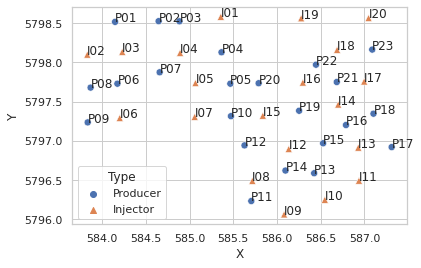

In [73]:
g = sns.scatterplot(
    data=locations.assign(X=locations["X"] / 1e3, Y=locations["Y"] / 1e3),
    x="X",
    y="Y",
    style="Type",
    hue="Type",
    markers=["o", "^"],
    s=50,
)
g.set(xlabel="X", ylabel="Y")
for i in range(locations.shape[0]):
    g.annotate(
        locations.index[i],
        (locations["X"].iloc[i] / 1e3, locations["Y"].iloc[i] / 1e3),
    )

[Text(0.5, 0, 'Distance from spreadsheet'),
 Text(0, 0.5, 'Distance from locations')]

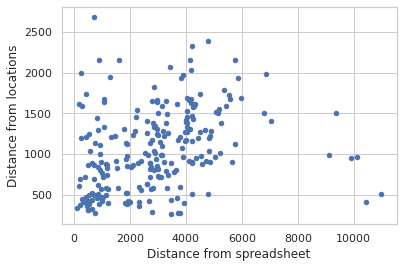

In [14]:
df.plot.scatter(x="Interwell Distance (m)", y="dist")
plt.gca().set(xlabel="Distance from spreadsheet", ylabel="Distance from locations")

[Text(0.5, 0, 'Angle from spreadsheet'), Text(0, 0.5, 'Angle from locations')]

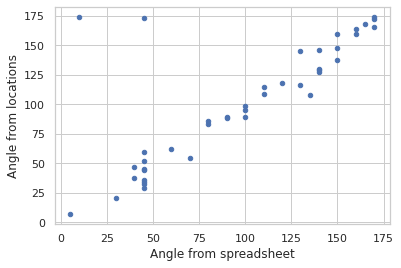

In [15]:
df.assign(angle2=lambda x: np.mod(x.angle * 180 / np.pi + 360, 180)).plot.scatter(
    x="Azimuth mod 180", y="angle2"
)
plt.gca().set(xlabel="Angle from spreadsheet", ylabel="Angle from locations")